# Testing code for my 2.5D forward simulation and inversion using simpeg

In this file I define all the functions explicitly, which in the `.py` files I import from `utils.py` instead.

In [48]:
import numpy as np
import glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    directives,
    inversion,
)
from simpeg.utils import model_builder
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_survey_from_abmn_locations,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

from discretize import TensorMesh
from discretize.utils import active_from_xyz

## Read in the survey layout from the res2dinv file, generate the survey and save the electrode positions as the topography

In [51]:
def res2dinv_to_survey(file_path):
    """
    Parse a Res2DInv file and generate a SimPEG DC survey and 2D topography.

    Parameters:
        file_path (str): Path to the Res2DInv .dat file.

    Returns:
        tuple: (survey, topo_2d)
            - survey (Survey): Generated DC resistivity survey.
            - topo_2d (ndarray): 2D array of electrode positions used as topography.
    """
    with open(file_path, "r") as file:
        lines = file.readlines()

    num_data_points = int(lines[6].strip())  # Number of data points

    # Read the data section
    A = np.zeros((num_data_points, 2))
    B = np.zeros((num_data_points, 2))
    M = np.zeros((num_data_points, 2))
    N = np.zeros((num_data_points, 2))
    dobs = np.zeros(num_data_points)
    error = np.zeros(num_data_points)

    data_start_line = 12
    for i, line in enumerate(
        lines[data_start_line : data_start_line + num_data_points]
    ):
        values = line.strip().split()
        if len(values) >= 11:
            A[i] = [float(values[1]), float(values[2])]
            B[i] = [float(values[3]), float(values[4])]
            M[i] = [float(values[5]), float(values[6])]
            N[i] = [float(values[7]), float(values[8])]
            dobs[i] = float(values[9])  # Voltage
            error[i] = float(values[10])  # Error percentage

    # Generate the survey
    survey = generate_survey_from_abmn_locations(
        locations_a=A, locations_b=B, locations_m=M, locations_n=N, data_type="volt"
    )

    # Topo from electrode positions (flat)
    topo_2d = np.unique(np.vstack([A, B, M, N]), axis=0)

    return survey, topo_2d

In [52]:
# read in the electrode locations from the res2dinv data file

file_path = "data/Project4_Wenner_1.dat"
survey, topo_2d = res2dinv_to_survey(file_path)

### Plot the electrode locations and resulting pseudolocations

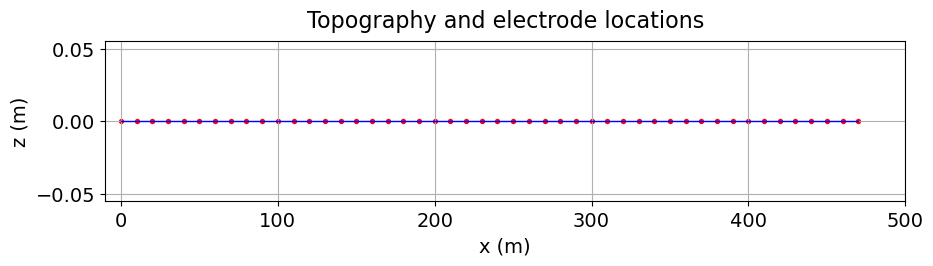

In [53]:
# plot topography with electrode positions
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:, 0], topo_2d[:, 1], color="b", linewidth=1)
ax.scatter(topo_2d[:, 0], topo_2d[:, 1], 8, "r")
ax.set_xlim([-10, 500])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and electrode locations", fontsize=16, pad=10)
plt.show(fig)

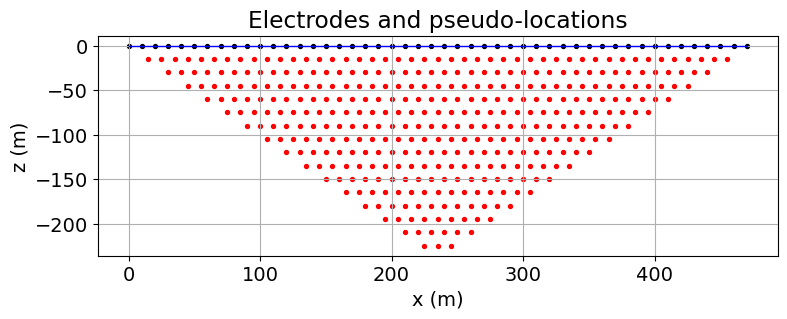

In [54]:
# plot pseudo-locations
pseudo_locations_xz = pseudo_locations(survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "r")
ax.plot(topo_2d[:, 0], topo_2d[:, 1], color="b", linewidth=1)
ax.scatter(topo_2d[:, 0], topo_2d[:, 1], 8, "k")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Electrodes and pseudo-locations")
ax.grid(True)
plt.show()

## Build and plot my tensor mesh

In [55]:
def build_tensor_mesh_padded(
    topo_2d,
    dx=5,
    dz=5,
    width=470,
    depth=100,
    pad_dist_x=125,
    pad_dist_z=125,
    pad_growth=1.3,
):
    """
    Create a 2D TensorMesh with roughly 5m cell sizes,
    extending 470m wide and 100m deep.

    Parameters:
    -----------
    topo_2d : (n, 2) array_like
        2D array of topography points [x, y] in the same coordinate system as the mesh.
    dx : float
        Horizontal cell size (default 5m)
    dz : float
        Vertical cell size (default 5m)
    width : float
        Total width of the mesh in meters
    depth : float
        Total depth of the mesh in meters

    Returns:
    --------
    mesh : discretize.TensorMesh
        The generated 2D TensorMesh.
    active_cells : np.ndarray
        Boolean array indicating which mesh cells are below topography.
    """
    ncx = int(width / dx)
    ncz = int(depth / dz)

    # Helper to compute padding cells
    def compute_padding_cells(cell_size, distance, factor):
        n = 0
        total = 0
        while total < distance:
            total += cell_size * (factor**n)
            n += 1
        return n

    # --- Padding cell counts ---
    npad_x = compute_padding_cells(dx, pad_dist_x, pad_growth)
    npad_z = compute_padding_cells(dz, pad_dist_z, pad_growth)

    # X direction: [left padding | core | right padding]
    hx = (
        (dx * pad_growth ** np.arange(npad_x)[::-1]).tolist()
        + [dx] * ncx
        + (dx * pad_growth ** np.arange(npad_x)).tolist()
    )

    # Y direction: [padding | core]
    hz = (dz * pad_growth ** np.arange(npad_z)[::-1]).tolist() + [dz] * ncz

    # --- Create mesh ---
    # x0: [origin_x, origin_y]
    # Since we want core to start at x=0, y=0 (top), we shift accordingly
    origin_x = -sum(hx[:npad_x])  # start of left padding
    # Place top of core at y = 0
    origin_z = -sum(hz)

    mesh = TensorMesh([hx, hz], x0=[origin_x, origin_z])

    # Indices of the active mesh cells from topography (e.g. cells below surface)
    active_cells = active_from_xyz(mesh, topo_2d)

    return mesh, active_cells

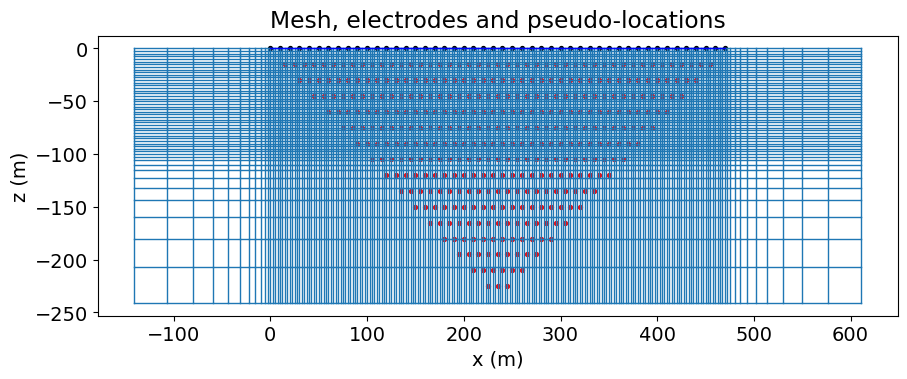

In [56]:
# build mesh
mesh, active_cells = build_tensor_mesh_padded(
    topo_2d,
    dx=2.5,
    dz=2.5,
    width=470,
    depth=100,
    pad_dist_x=125,
    pad_dist_z=125,
    pad_growth=1.3,
)


# plot mesh
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
ax1.plot(topo_2d[:, 0], topo_2d[:, 1], color="b", linewidth=1)
ax1.scatter(topo_2d[:, 0], topo_2d[:, 1], 8, "k")
ax1.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "r")
# ax1.set_xlim(0, width)
# ax1.set_ylim(-depth, np.max(topo_2d[:, 1]) + 10)
ax1.set_title("Mesh, electrodes and pseudo-locations")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

plt.show()

## Define the active cells (not air) 

In [57]:
# number of active cells
n_active = np.sum(active_cells)

## Build my synthetic resistivity model

In [65]:
def build_model(mesh, active_cells):
    """
    Build a synthetic resistivity model with ice lens and wedge (or edit accordingly from within utils.py file)

    Parameters:
        mesh (TreeMesh): The discretized mesh used for modeling.
        active_cells (ndarray): Boolean array indicating active cells.

    Returns:
        tuple: (resistivity_model, resistivity_map, plotting_map)
            - log_resistivity_model (ndarray): 1D array of resistivity values.
            - log_resistivity_map (Map): Map to inject air resistivity into inactive cells.
            - plotting_map (Map): Map to inject NaN into inactive cells for plotting.
    """
    n_active = np.sum(active_cells)

    # Make model
    air_resistivity = 1e8
    active_resistivity = 10
    permafrost_resistivity = 1000
    ice_resistivity = 5000
    unfrozen_resistivity = 100

    # without active layer
    resistivity_model = model_builder.create_layers_model(
        mesh,
        layer_tops=np.array([0, -50]),
        layer_values=np.array([permafrost_resistivity, unfrozen_resistivity]),
    )

    # # add block
    # ind_ice = model_builder.get_indices_block(
    #     np.r_[240, 00], np.r_[260, -40], mesh.cell_centers[active_cells, :]
    # )
    # resistivity_model[ind_ice] = ice_resistivity

    # convert to log space
    log_resistivity_model = np.log(resistivity_model)

    log_resistivity_map = maps.InjectActiveCells(
        mesh, active_cells, np.log(air_resistivity)
    ) * maps.ExpMap(nP=n_active)

    # Generate a mapping to ignore inactice cells in plot
    plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

    return log_resistivity_model, log_resistivity_map, plotting_map

In [66]:
log_resistivity_model, log_resistivity_map, plotting_map = build_model(
    mesh, active_cells
)

## Map the resistivity model to the mesh cell locations

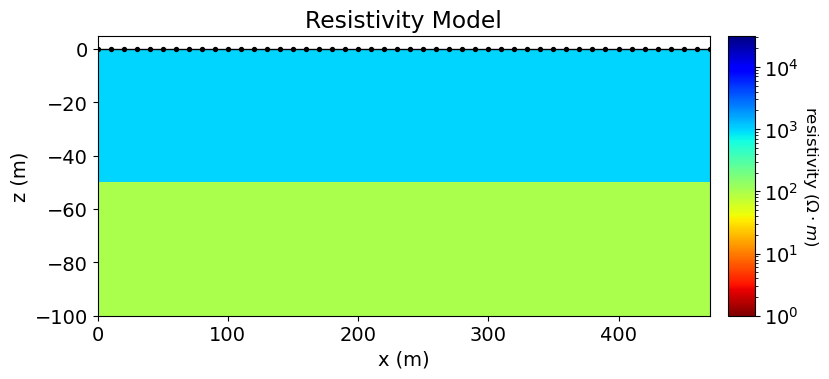

In [67]:
fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1, vmax=10 ** (4.5))

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * np.exp(log_resistivity_model),
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.jet_r},
)
ax1.plot(topo_2d[:, 0], topo_2d[:, 1], color="k", linewidth=1)
ax1.scatter(topo_2d[:, 0], topo_2d[:, 1], 8, "k")

ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.max(topo_2d[:, 1]) - 100, np.max(topo_2d[:, 1] + 5))
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")


ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet_r
)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

### Ensure the electrodes are at the surface (not above or below)

In [68]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define the forwards simulation, and get the predicted data, then plot in a pseudosection

In [69]:
# DC simulation for a log resistivity model
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=log_resistivity_map, storeJ=True
)

dpred = simulation.dpred(log_resistivity_model)

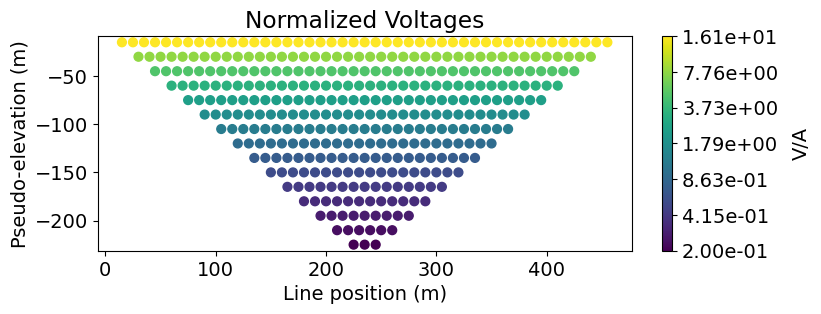

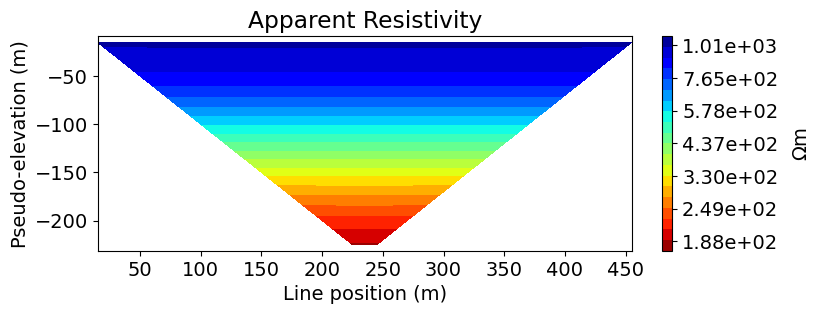

In [70]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=np.abs(dpred),
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(survey, dpred)

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=apparent_resistivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="$\Omega$m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.jet_r},
)
ax1.set_title("Apparent Resistivity")
plt.show()

## Add 5% random noise to the simulated data, then save this as a data object to be used in the following inversion

In [71]:
def make_data(survey, clean_data, std):
    """
    Generate synthetic observed data by adding Gaussian noise to clean voltage data.

    Parameters:
    -----------
    survey : Survey
        DC resistivity survey object.
    clean_data : np.ndarray
        Clean synthetic voltage data (noiseless).
    std : float or np.ndarray
        Relative noise level (e.g., 0.05 for 5%) or array of standard deviations.

    Returns:
    --------
    data_dc : Data
        SimPEG Data object containing noisy observations and associated uncertainties.
    """
    # Add 5% Gaussian noise to each datum
    rng = np.random.default_rng(seed=225)
    error = 1e-5 + std * np.abs(clean_data)
    dc_noise = rng.normal(scale=error, size=len(clean_data))
    dobs = clean_data + dc_noise

    data_dc = data.Data(survey, dobs=dobs, standard_deviation=error)

    return data_dc

In [72]:
# add noise to simulate real situation and make it into a data object for the inversion
data_dc = make_data(survey, dpred, std=0.05)

# 2.5D Least-squares inversion

### Define a starting model as the bedrock resistivity

In [73]:
def build_starting_model(survey, dpred, active_cells):
    """
    Create a homogeneous starting resistivity model from the average apparent resistivity.

    Parameters:
    -----------
    survey : Survey
        DC resistivity survey object.
    dpred : np.ndarray
        Predicted voltage data from a forward model.
    active_cells : np.ndarray
        Boolean array indicating which cells are active in the inversion.

    Returns:
    --------
    starting_resistivity_model : np.ndarray
        1D array of starting resistivity values for active cells.
    """
    apparent_resistivities = apparent_resistivity_from_voltage(survey, dpred)
    average_resistivity = np.mean(apparent_resistivities)
    nC = int(active_cells.sum())
    starting_resistivity_model = average_resistivity * np.ones(nC)
    return starting_resistivity_model

In [74]:
# Define model
starting_log_resistivity_model = build_starting_model(survey, dpred, active_cells)

# Define the data misfit. 
Here the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model.

Within the data misfit, the residual between predicted and observed data are normalized by the data's standard deviation.

In [75]:
# define data misfit
dmis = data_misfit.L2DataMisfit(data=data_dc, simulation=simulation)

# least-squares regularization
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    alpha_s=1,
    alpha_x=1,
    alpha_y=1,
    reference_model=starting_log_resistivity_model,
    reference_model_in_smooth=True,
)

### Optimization and setting up the inverse problem

In [76]:
# Define how the optimization problem is solved. Here we will use an Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(
    maxIter=40,
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Inversion Directives

In [77]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=True)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

## Carry out inversion and plot

In [78]:
# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_log_resistivity_model = dc_inversion.run(starting_log_resistivity_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)
/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/simpeg/base/pde_simulation.py:30: RuntimeWarning: overflow encountered in multiply
  return M.T * (u * v)
/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/simpeg/electromagnetics/static/resistivity/simulation_2d.py:703: RuntimeWarning: overflow encountered in multiply
  out += self._MBC_sigma[ky].T @ (u * v)
/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/simpeg/directives/directives.py:2878: RuntimeWarning: invalid value encountered in divide
  wr /= wr.max()
/Users/cara/opt/min

simpeg.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2025-04-22-22-13.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0    nan       inf       nan       nan          nan        0              
------------------------------------------------------------------
0 :    ft     = nan <= alp*descent     = nan
1 : maxIterLS =      10    <= iterLS          =     10
------------------------- End Linesearch -------------------------
The linesearch got broken. Boo.


In [ ]:
def load_all_models(directory):
    """
    Load all .npy inversion model files from a directory into a list.

    Parameters:
    -----------
    directory : str
        Directory containing .npy inversion model files.

    Returns:
    --------
    models : list of np.ndarray
        List of 1D numpy arrays, one per model.
    """
    files = sorted(glob.glob(os.path.join(directory, "*InversionModel*.npy")))

    if not files:
        print(f"No model files found in {directory}")
        return []

    models = [np.load(f) for f in files]
    return models

In [ ]:
vmin = 30
vmax = 10 ** (4.5)

# look at the iterations
models = load_all_models(".")
for i, model in enumerate(models):
    title = f"Inversion iteration {i+1}"
    plot_results(
        mesh,
        plotting_map,
        topo_2d,
        np.exp(model),
        title=title,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )

In [ ]:
fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e2, vmax=1e5)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * resistivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.jet},
)
ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.max(topo_2d[:, 1]) - 200, np.max(topo_2d[:, 1] + 5))
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e2, vmax=1e5)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * recovered_resistivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.jet},
)
ax1.set_xlim(np.min(topo_2d[:, 0]), np.max(topo_2d[:, 0]))
ax1.set_ylim(np.max(topo_2d[:, 1]) - 200, np.max(topo_2d[:, 1] + 5))
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.jet
)
cbar.set_label(r"resistivity ($\Omega \cdot m$)", rotation=270, labelpad=15, size=12)

plt.show()

In [ ]:
recovered_resistivity_model_2d = recovered_resistivity_model.reshape(
    mesh.shape_cells, order="F"
)

drop_threshold = 100

x_locs = mesh.cell_centers_x
z_locs = mesh.cell_centers_y

nz = mesh.shape_cells[1]
interface_depths = np.full_like(x_locs, np.nan, dtype=float)

# Ensure z goes from shallow (top) to deep (bottom)
sort_z = np.argsort(z_locs)
z_sorted = z_locs[sort_z]

for i, x in enumerate(x_locs):
    res_col = recovered_resistivity_model_2d[i, :]  # grab column (bottom to top?)
    res_col_sorted = res_col[sort_z]

    dz = np.diff(z_sorted)
    dres = np.diff(res_col_sorted)
    grad = dres / dz

    drop_inds = np.where(grad < -drop_threshold)[0]
    if drop_inds.size > 0:
        idx = drop_inds[0]
        interface_depths[i] = (z_sorted[idx] + z_sorted[idx + 1]) / 2

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
mesh.plot_image(
    recovered_resistivity_model_2d,
    ax=ax,
    grid=False,
    pcolor_opts={"cmap": "viridis", "norm": "log"},
)
ax.plot(x_locs, interface_depths, "r-", lw=2, label="Detected Resistivity Drop")
ax.set_title("Resistivity Model with First Drop Interface")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.legend()
plt.gca().set_aspect("equal")
plt.show()